# New notebook

In [1]:
import os
from skimage import io
from sklearn.decomposition import PCA, NMF

# dsci
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_li

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
ds = 'ani18_2021-xx-xx_b'

In [3]:
#loading tiff as numpy
tiff = io.imread(f'../data/{ds}/suite2p/plane0/reg_tiff/mot_corr_concat.tif') 
#one directtory up from scripts
print(f'Shape of video: {tiff.shape}') 
n_frames = tiff.shape[0] 
x_axis = tiff.shape[1]
y_axis = tiff.shape[2]
tiff_flat = np.reshape(tiff, (n_frames, x_axis*y_axis)) # or tiff.reshape(6000, 315*315) #if (( its tuple if [ its a list tiff
print(f'Shape of re_shaped video: {tiff_flat.shape}') 


Shape of video: (6000, 315, 315)
Shape of re_shaped video: (6000, 99225)


In [10]:
n_components = 20
blur_std = 6.5 #blurs nmf outputs
manual_thresh = 3 
thr = 3

In [5]:
#INITIALIZING NMF AND FITIING PCA ON PIXELS 
nmf_px = NMF(n_components=n_components)
nmf_px.fit(tiff_flat)

C:\Users\jcplatel\Anaconda3\envs\suitep\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\jcplatel\Anaconda3\envs\suitep\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=20)

In [6]:
def get_thr_img_manual(loading_img, blur_std, manual_thresh):
    
    fig, axs = plt.subplots(1, 3, dpi=200)

    loading_img_filt = gaussian_filter(loading_img, blur_std) #defining filtered with gaussian and bluring
    roi = loading_img_filt>manual_thresh # definig what an nmf is or thresholding 
    axs[0].imshow(loading_img)
    axs[1].imshow(loading_img_filt)
    axs[2].imshow(roi) # arbitrary threshold

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

    axs[0].set_title('NMF')
    axs[1].set_title('Gaussian blur')
    axs[2].set_title('Thresholded (manual)')

    plt.show()
    
    return roi


NameError: name 'roi' is not defined

In [ ]:
def get_thr_img_auto(loading_img, blur_std, i, axs):

    loading_img_filt = gaussian_filter(loading_img, blur_std)

    auto_thresh = threshold_li(loading_img_filt) #Li thershold on loading_img_filt

    roi = loading_img_filt > auto_thresh #finallyd efining roi or nmf as when the filtered blurred img values are > thresholded
    
    axs[i,0].imshow(loading_img)
    axs[i,1].imshow(loading_img_filt)
    axs[i,2].imshow(roi) # arbitrary threshold

    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,2].axis('off')
    
    axs[i,0].set_xlabel(f'NMF{i+1}', fontsize=100)
    
    if i == 0:
        
        axs[i,0].set_title('NMF', fontsize=5)
        axs[i,1].set_title('Gaussian blur', fontsize=5)
        axs[i,2].set_title('Thresholded (Li)', fontsize=5)

    
    
    return roi

In [ ]:
fig, axs = plt.subplots(n_components, 3, dpi=300, figsize=(3,n_components))

rois_manual = []
rois_auto = [] #list
for i in range(0,n_components):
    loading = nmf_px.components_[i,:] # attr of nmf object
    loading_img = loading.reshape(x_axis, y_axis) #reshape ith nmf
   
    
    #roi_manual = get_thr_img_manual(loading_img, blur_std, manual_thresh)
    roi_auto = get_thr_img_auto(loading_img, blur_std, i,axs) #blur and thresh

    
   # rois_manual.append(roi_manual)
    rois_auto.append(roi_auto) #add it to the list, fisrt iteration list is empty, after second iteration 1 nmf gets into teh lsit as threshloded matrix pf t and f
    print(rois_auto)
    #i have to create the empty list rois_auto to fillit and keep the outputs, if not each iteration will overrun and no output will be saved


In [ ]:
plt.figure(figsize=(10,10))

for (i, roi) in enumerate(reversed(rois_manual)): # reversed to plot more obvious components first
    if i != 5:
        roi_scat = np.nonzero(roi)
        plt.scatter(roi_scat[1], -roi_scat[0], marker='s', s=1, alpha=0.4) # - is because of image processing conventions
        plt.ylim((-y_axis, 0))
        plt.xlim((0,x_axis))
        plt.axis('off')
plt.show()


In [ ]:

for (i, roi) in enumerate(reversed(rois_auto)): # reversed to plot more obvious components first
    if i != 13:
        roi_scat = np.nonzero(roi)
        plt.scatter(roi_scat[1], -roi_scat[0], marker='s', s=9, alpha=0.4) # - is because of image processing convention
        plt.ylim((-y_axis, 0))
        plt.xlim((0,x_axis))
        plt.axis('off')
plt.show()

In [ ]:
os.chdir('..')

In [ ]:
save_path = os.getcwd() + '/data/' + ds + '/patch_sz/'

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
print('SavePath: ', save_path)

In [ ]:
from skimage.measure import find_contours

In [ ]:
# exporting rois
plt.figure(figsize=(10,10))

for (i, roi) in enumerate(rois_auto):
    
    roi_bounds = np.absolute(np.gradient(roi.astype(int), axis=0))
    roi_scat = np.nonzero(roi_bounds)
    
    roi_cont = find_contours(roi)
    
    if len(roi_cont) == 1: # this now biases to a single selection!!! but could also run an inner loop for multi-contour rois

        plt.plot(roi_cont[0][:,1], roi_cont[0][:,0], linewidth=5, alpha=0.7)
    
        plt.ylim((y_axis, 0))
        plt.xlim((0,x_axis))
        plt.axis('off')


        with open(save_path + f'nmf{i+1}_roi.txt', 'w') as f:

            for j in range(len(roi_cont[0])):

                f.write(f'{roi_cont[0][j,1]}    {roi_cont[0][j,0]}\n')



In [ ]:
roi_cont[0][0,j]

In [ ]:
len(roi_cont[0])

In [ ]:
#Trying to find each nmf area 

In [ ]:
area_of_nmf = [] #list is the class, this is is an object of class list, list that will be filled by the area outputs at the ebd of the loop, then i ll append this 
list_length = len(rois_auto) #defining the lenth of the list i wanna iterate through
len(rois_auto)


for i in range(list_length): 
   
    true_pixels = np.sum(rois_auto[i])  # attr of nmf object    
    array = area_of_nmf.append(true_pixels)
    
print(area_of_nmf)

area = [np.sum(roi) for roi in rois_auto]
plt.hist(area, 50)


In [ ]:
area = [np.sum(roi) for roi in rois_auto]
plt.hist(area, 50)


In [ ]:
print(area_of_nmf)

res= 1.07
resolution = res**res
area = summed_area(i)*resolution
area_of_nmf = [summed_area(i)*resolution, n_component

In [ ]:
#np.sum for this roi or like add all non zeors, it ll take false as 0 and true as 1
# i have  a list of matrices and matrices qare numpy arrays so i ll find a function for them

In [ ]:
area_of_nmf.append(summed_area)
print(area_of_nmf)

counter = 0 

if indexraw == True
counter +=

In [ ]:
sum(rois_auto[True] for rois_auto:
    print(sum)
          

In [ ]:
sum = sum[rois_auto]

In [ ]:
#for nmf in nmfs:
	sum all nonzeros
	area_in_um = multiply by resolution^2
	save area_in_um for this nmf

make histogram of all area_in_um

# new notebook

In [7]:
#INITIALIZING PCA AND FITIING PCA ON PIXELS transposed matrix 
nmf_t = NMF(n_components=n_components)
nmf_t.fit(tiff_flat.T)

C:\Users\jcplatel\Anaconda3\envs\suitep\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\jcplatel\Anaconda3\envs\suitep\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=20)

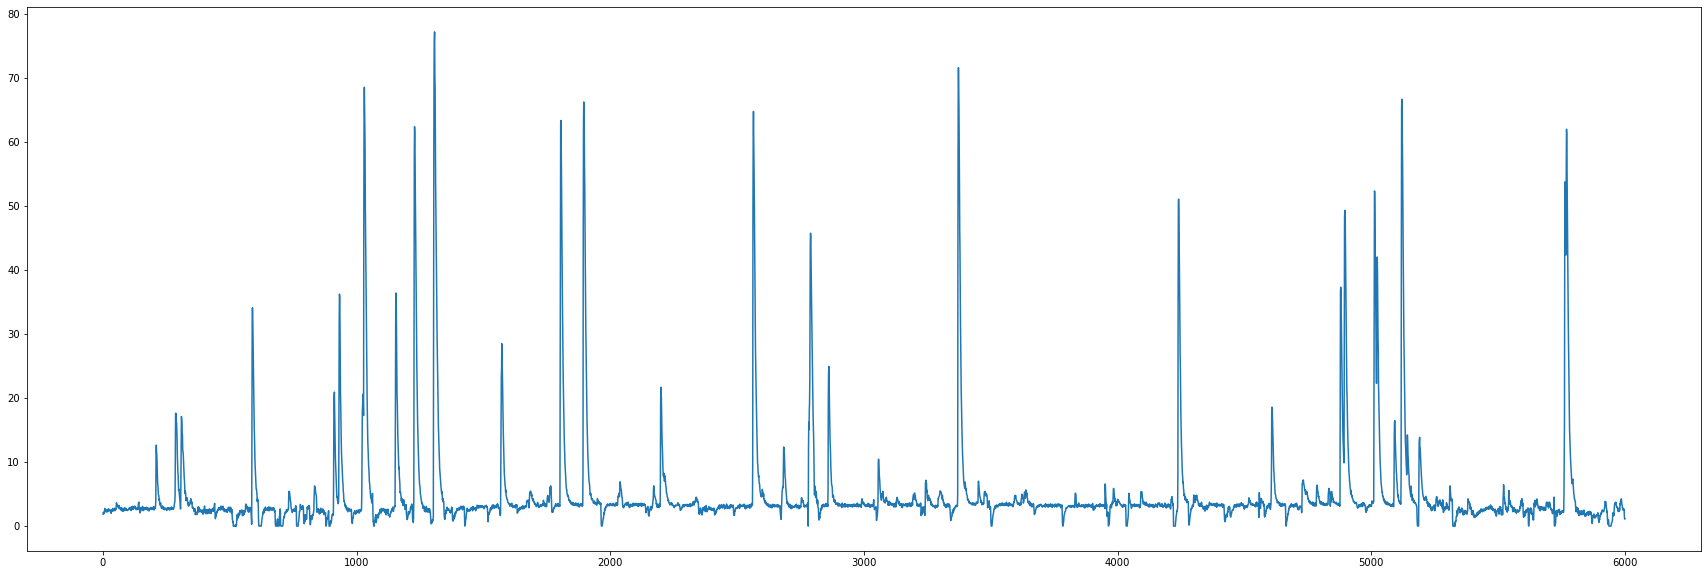

In [8]:
plt.figure(figsize=(30,10))
plt.plot(nmf_t.components_[1, :]) #activity in time of each patch 

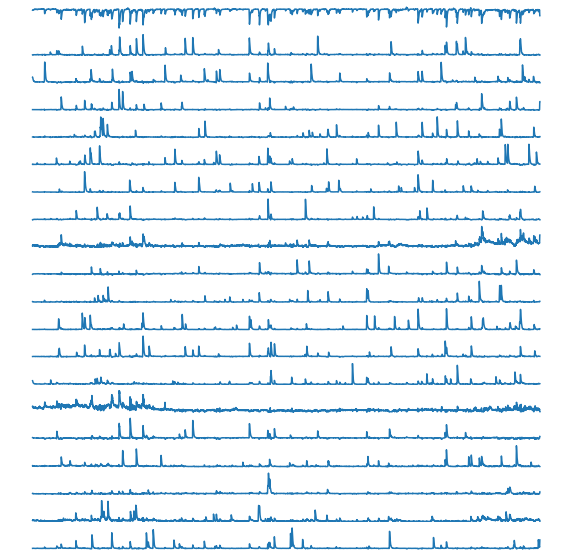

In [9]:
fig, axs = plt.subplots(n_components, 1, figsize=(10,10))

for i in range(n_components):
    axs[i].plot(nmf_t.components_[i, :])
    axs[i].axis('off')

plt.show()



In [20]:
 #threshold the nmfs activity
thr=2
thresholded_nmf = nmf_t.components_[1, :] > thr
print(thresholded_nmf)

[False  True  True ... False False False]


In [21]:
nmf_t_mat = np.asarray(nmf_t.components_)
nmf_px_mat = np.asarray(nmf_px.components_)

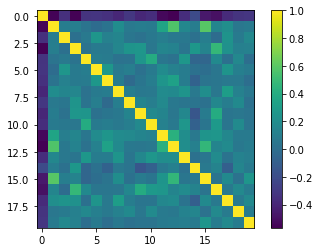

In [22]:
plt.imshow(np.corrcoef(nmf_t_mat))
plt.colorbar()

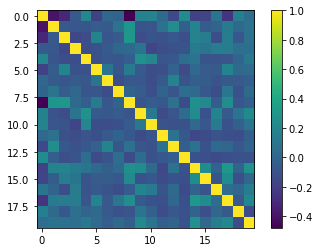

In [23]:
plt.imshow(np.corrcoef(nmf_px_mat))
plt.colorbar()